In [140]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps
from scipy import stats
import math 
import statistics 
from scipy.integrate import quad
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import chi2

In [2]:
x = np.array([5,8,6,12,14,18,11,6,13,7])
N = 100
#x_arr = np.array([[i]*x[i] for i in range(0, 10)])

In [3]:
#x_arr

In [4]:
x_arr = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 
                 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7,
                 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9])

## a

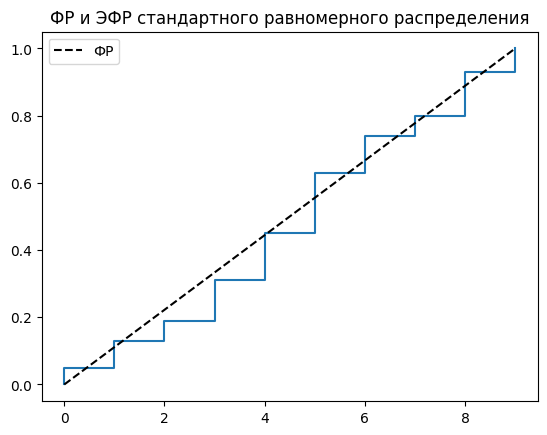

In [38]:
def plot_ecdf(values, xlim):
    """Построить график ЭФР."""
    X_ = sorted(set(values))
    Y_ = [np.mean(values < x) for x in X_]
    X = sum([[v, v] for v in X_], [])
    Y = sum([[v, v] for v in Y_], [])
    Y = Y[1:]+[1]
    plt.plot(X, Y)
    return Y

# Генерируем данные  и строим ЭФР
Y_ecdf = plot_ecdf(x_arr, [0, 9])

# Строим ФР
X = np.arange(0, 10)
Y = stats.uniform.cdf(X, loc = 0, scale = 9)
plt.plot(X, Y, '--', color='k', label='ФР')

plt.title('ФР и ЭФР стандартного равномерного распределения')
plt.legend()
plt.show()

In [39]:
delta_ = max(abs(Y.repeat(2)-Y_ecdf))*100**0.5
delta_ 

1.4333333333333331

In [7]:
p_value = 0
for i in range(1,1000):
    p_value += -2*(-1**i)*np.exp(-2*i**2*delta_**2)
print(f"p_value = {p_value}")

p_value = 0.032852176636945195


## b

In [8]:
limits = np.array(-np.inf)
limits = np.append(limits, np.arange(0.5, 9, 1))
limits = np.append(limits, np.inf)

In [9]:
def integrand(x, sigma, m):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-m)**2/(2*sigma**2)) #a*x**2 + b
#I = quad(integrand, 0, 1, args=(a,b))

In [16]:
def best_param(x):
    maxim = 0 
    sigma_ = 0
    m_ = 0
    for sigma in np.arange(2, 3, 0.1):
        for m in np.arange(3, 5, 0.1):
            L = 1 
            for i in range(0, len(limits)-1, ):
                L *= quad(integrand, limits[i], limits[i+1], args = (sigma, m))[0]**x[i]
            if (L > maxim):
                maxim, sigma_, m_ = L, sigma, m
    return sigma_, m_

In [55]:
sigma_, m_ = best_param(x)
print(sigma_, m_)        

2.7000000000000006 4.800000000000002


In [101]:
probabilities = np.array([quad(integrand, limits[i], limits[i+1], args = (sigma_, m_))[0] for i in range(0, len(limits)-1)])

In [102]:
probabilities 

array([0.05562581, 0.05518599, 0.08633636, 0.11793901, 0.14067695,
       0.14651828, 0.13324914, 0.10581321, 0.0733696 , 0.08528566])

In [103]:
delta_b = 0
for i in range(len(x)):
    delta_b += (x[i]-N*probabilities[i])**2/(N*probabilities[i])

In [104]:
print(f"delta in X^2 = {delta_b}")

delta in X^2 = 9.779231990914937


## b Kolmogorov

In [60]:
arr_f = np.array([])
for i in range(0,10):
    arr_f =  np.append(arr_f, quad(integrand, -np.inf, i, args = (sigma_, m_))[0])

In [61]:
delta_b_kol = max(abs(arr_f.repeat(2) - Y_ecdf))*np.sqrt(N)
print(f"basic delta in Kolmogorov = {delta_b_kol}")

basic delta in Kolmogorov = 1.0047572223260304


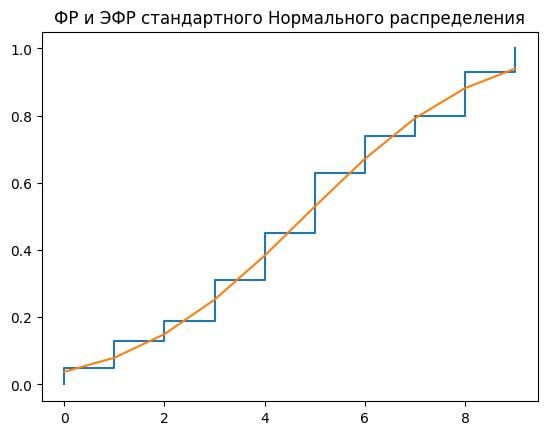

In [62]:
plot_ecdf(x_arr,[0,9])
plt.plot(np.arange(0,10), arr_f)
plt.title('ФР и ЭФР стандартного Нормального распределения')
plt.show() 

In [65]:
%%time

delta_arr = np.array([])
for i in range(0, 10000):
    if not i%1000:
        print(i)
    bootstrap = np.sort(np.random.choice(x_arr, size = N))
    count = np.array([])
    for i in [0,1,2,3,4,5,6,7,8,9]: # there may not be a number in bootstrap
        count = np.append(count, sum(bootstrap == i)) 
    sigma_i, m_i = best_param(count)
    arr_f = np.array([])
    for j in range(0,10):
        arr_f =  np.append(arr_f, quad(integrand, -np.inf, j, args = (sigma_i, m_i))[0])
    delta_arr = np.append(delta_arr, max(abs(arr_f.repeat(2) - Y_ecdf))*np.sqrt(N))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
CPU times: total: 53min 28s
Wall time: 53min 30s


In [67]:
delta_arr.sort()  

In [85]:
k_ = sum(delta_arr < delta_b_kol)
k_ += 1

p_value_b_kol = 1 - (k_ - 1)/10000
print(f"p_value by Kolmogorov and parametric_bootstrap = {p_value_b_kol}")

p_value by Kolmogorov and parametric_bootstrap = 0.8602


## Значит нет оснований отвергнуть основную гипотезу о согласии данных с законом нормального распределения

## c 

In [142]:
a1 = np.mean(x_arr)
a2 = np.mean(x_arr**2) 
m_c = a1
sigma_c = (a2 - a1**2)**0.5

In [143]:
probabilities_c = np.array([quad(integrand, limits[i], limits[i+1], args = (sigma_c, m_c))[0] for i in range(0, len(limits)-1)])

In [144]:
delta_c = 0
for i in range(len(x)):
    delta_c += (x[i] - probabilities_c[i]*100)**2/(100*probabilities_c[i])

In [145]:
delta_c

10.79897314050092

In [131]:
delta_arr_c = np.array([])

for i in range(0, 50000):
    bootstrap = np.sort(np.random.choice(x_arr, size = N))
    count = np.array([])
    for i in [0,1,2,3,4,5,6,7,8,9]: # there may not be a number in bootstrap
        count = np.append(count, sum(bootstrap == i)) 
        
    delta_i = 0
    m_i = np.mean(bootstrap)
    sigma_i = (np.mean(bootstrap**2) - m_i**2)**0.5
    
    probabilities_i = np.array([quad(integrand, limits[i], limits[i+1], args = (sigma_i, m_i))[0] for i in range(0, len(limits)-1)])
    for j in range(0,10):
        delta_i +=  (count[i] - probabilities_i[j]*100)**2/(100*probabilities_i[j])
    delta_arr_c = np.append(delta_arr_c, delta_i)

In [134]:
delta_arr_c.sort()

In [138]:
k_c = sum(delta_arr_c < delta_c)
k_c += 1

p_value_c = 1 - (k_c - 1)/50000
print(f"p_value and parametric_bootstrap = {p_value_c}")

p_value and parametric_bootstrap = 0.98102


In [186]:
m_c, sigma_c

(4.77, 2.5054141374231933)

## Значит нет оснований отвергнуть основную гипотезу о согласии данных с законом нормального распределения (параметры распределения получены методом моментов)

## Сравнение
$$
\chi^2(k-1)\\
\chi^2(k-3)\\
N(4.77,\; 2.5^2)\\
$$

In [167]:
def integrand_Xi(x, k):
    return (x**(k/2-1))*np.exp(-x/2)/(2**(k/2)*math.gamma(k/2))

In [175]:
arr_f_с = np.array([])
arr_f_x9 = np.array([]) #(10-1)
arr_f_x7 = np.array([]) #(10-3) k= 10
for i in range(0,20):
    arr_f_с =  np.append(arr_f_с, quad(integrand, -np.inf, i, args = (sigma_c, m_c))[0])
    arr_f_x7 =  np.append(arr_f_x7, quad(integrand_Xi, 0, i, args = 7)[0])
    arr_f_x9 =  np.append(arr_f_x9, quad(integrand_Xi, 0, i, args = 9)[0])

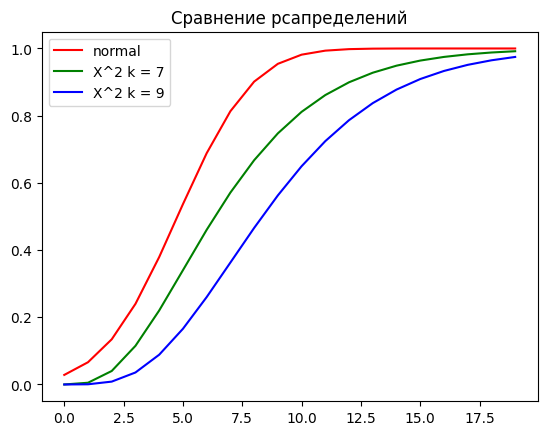

In [185]:
plt.plot(np.arange(0,20), arr_f_с, label="normal", color = 'red')
plt.plot(np.arange(0,20), arr_f_x7, label = "X^2 k = 7", color = 'green')
plt.plot(np.arange(0,20), arr_f_x9, label = "X^2 k = 9", color = "blue")
plt.title("Сравнение рсапределений")
plt.legend()
plt.show()